In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
train = pd.read_csv('Google_Stock_Price_Train.csv', index_col = 'Date')
test = pd.read_csv('Google_Stock_Price_Test.csv', index_col = 'Date')
# test = pd.concat([train, test])

In [3]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

train = pd.DataFrame(train)
test = pd.DataFrame(test)


train_x = torch.from_numpy(train[0 : -1].values).float()
train_y = torch.from_numpy(np.delete(train[0].values, 0)).float()

test_x = torch.from_numpy(test[0 : -1].values).float()
test_y = torch.from_numpy(np.delete(test[0].values, 0)).float()

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(RNN, self).__init__()
        self.bidirectional = False
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = 4
        self.bias = True
        self.gru = nn.GRU(input_size, hidden_layer_size, self.num_layers, bias = self.bias,
                            bidirectional = self.bidirectional)
        
        self.hidden_cell = self.init_hidden()
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
    def init_hidden(self):
        self.hidden_cell = torch.zeros((int(self.bidirectional) + 1) * self.num_layers, 1, self.hidden_layer_size).to(device)
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.gru(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out)
        return predictions

In [5]:
rnn = RNN(5, 64, 1).cuda(device)
train_x = train_x.cuda(device)
train_y = train_y.view(-1, 1, 1).cuda(device)
lr = 0.01
optimizer = torch.optim.Adam(rnn.parameters(), lr)
criterion = nn.MSELoss()

In [6]:
epoch_num = 100
losses = []
for i in range(epoch_num):
    rnn.hidden_cell = rnn.init_hidden()
    optimizer.zero_grad()
    
    output = rnn(train_x)
    loss = criterion(output, train_y)

    loss.backward()
    losses.append(loss.item())
    optimizer.step()

In [7]:
print(loss)

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)


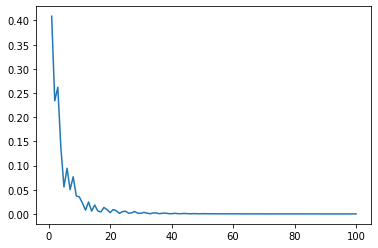

In [8]:
import matplotlib.pyplot as plt
nploss = np.array(losses)
plt.plot(range(1, len(losses) + 1), nploss)

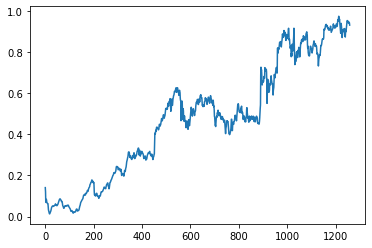

In [9]:
xx = output.cpu().detach().numpy()
xxx = xx.reshape(1257)
plt.plot(range(1, len(xxx) + 1), xxx)

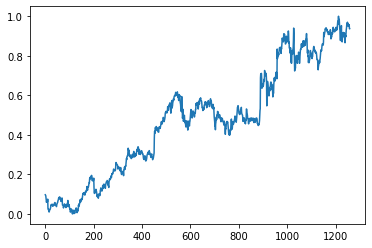

In [10]:
yyy = train_y.cpu().detach().numpy()
yyy = yyy.reshape(1257)
plt.plot(range(1, len(yyy) + 1), yyy)

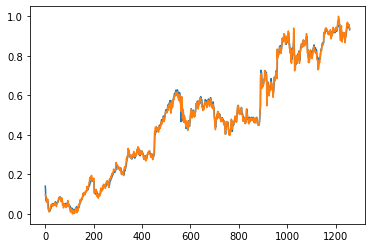

In [11]:
plt.plot(range(1, len(xxx) + 1), xxx)
plt.plot(range(1, len(yyy) + 1), yyy)

In [12]:
test_x = torch.from_numpy(test[0 : -1].values).float()
test_x = test_x.cuda(device)
predict = rnn(test_x)

In [19]:
a = np.load('a.npy')

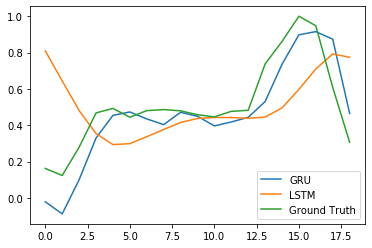

In [29]:
p = predict.cpu().detach().numpy()
pp = p.reshape(p.shape[0])
plt.plot(range(len(pp)), pp)
plt.plot(range(len(a)), a)
ty = test_y.numpy()
plt.plot(range(len(ty)), ty)
plt.legend(["GRU","LSTM","Ground Truth"])

In [26]:
lstml = np.load("losses.npy")

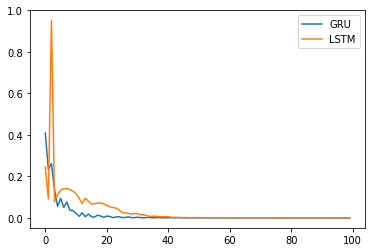

In [28]:
plt.plot(range(len(losses)), nploss)
plt.plot(range(len(lstml)), lstml)
plt.legend(["GRU","LSTM"])